### Introduction
This example examines some issues in practice about
Gaussian process (GP) models (a sepia emulator)
when the response is known to be linear or nearly-linear.

The main issue is that the GP's marginal
response is a Gaussian distribution. Sepia's default
setup is that the marginal response is approximately
N(0,1), and it is normally set up so that the y
responses are standardized to N(0,1).

If the y responses are linear, however, the GP in this
case will attempt to conform the response locally to
N(0,1), effectively "bending the line" back around to
the prior process domain.

This will all be over-ridden locally given the simulator
data, where 'locality' depends on both the values and priors
of various sepia parameters as well as the amount of
data. Small data will provide less effect on the
posterior (fitted) process.

First, set up a simple calibration problem, with the
simulator being a linear response. This also includes
options to over-ride some sepia model parameters.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sepia import SepiaData, SepiaModel, SepiaPlot, \
    SepiaEmulatorPrediction, SepiaFullPrediction

def run_model(m=20, fix_lamUz=False, fix_lamWs=False, fix_lamWOs=False, fix_lamOs=False):
    t_sim=np.linspace(1,4,m).reshape((-1,1))
    y_sim=np.linspace(4,1,m).reshape((-1,1))
    y_obs=np.ones((1,1))*2

    dat=SepiaData(t_sim=t_sim,y_sim=y_sim,y_obs=y_obs)
    dat.standardize_y()
    dat.transform_xt()

    mod=SepiaModel(dat)

    # The if statements change default sepia model parameters based
    # on flags passed in. By default, these are all false.
    # When a value is passed in, the parameter is set to that value,
    # it is set to 'fixed' (not sampled), and the bounds are set
    # to make sure the defaults do not exclude the value
    if fix_lamUz:
        # Process precision - make it  so it's not forcing N(0,1) marginal response locally
        mod.set_param('lamUz',fix=fix_lamUz)
    if fix_lamWs:
        # Nugget / noise process variance for simulations
        mod.set_param('lamWs',fix=fix_lamWs)
    if fix_lamWOs:
        # Scaling of simulator error
        # (which is relevant to allocating relative uncertainty for multivariate response)
        mod.set_param('lamWOs',fix=fix_lamWOs)
    if fix_lamOs:
        # Scaling of observation error
        mod.set_param('lamOs',fix=fix_lamOs)

    # "fit" the model by generating posterior samples
    mod.do_mcmc(100)  # go past transient
    mod.clear_samples()
    mod.do_mcmc(1000) # collect samples

    return mod

And some plotting routines

In [2]:
def plot_trace(mod):
    #call the trace plot built-in with the samples
    SepiaPlot.mcmc_trace(mod.get_samples())
    plt.show()

def plot_cal(mod):
    # plot the calibration setup and results
    psamp=mod.get_samples(numsamples=100)
    t_pred=np.linspace(0,5,50).reshape((-1,1))
    spred=SepiaEmulatorPrediction(t_pred=t_pred, model=mod, samples=psamp)
    ysp=spred.get_y()
    yspm=np.mean(ysp,axis=0).squeeze()
    ysps=np.std(ysp,axis=0).squeeze()

    opred=SepiaFullPrediction(model=mod,samples=psamp)
    yop=opred.get_yobs()

    fig,ax1 = plt.subplots()
    ax1.plot(t_pred,yspm,'k')
    ax1.plot(t_pred,yspm+2*ysps,'k.')
    ax1.plot(t_pred,yspm-2*ysps,'k.')
    ax1.plot(mod.data.sim_data.t,mod.data.sim_data.y,'go')
    ax1.plot(psamp['theta_native'],yop.squeeze(),'r.')
    calx=np.array([0,5]).reshape((-1,1))
    ax1.plot(calx,np.ones((2,1))*mod.data.obs_data.y,'b')
    ax2=ax1.twinx()
    sns.histplot(psamp['theta_native'],kde=True,color='r',ax=ax2,legend=False)
    ax2.set_ylabel(''); ax2.set_yticks([]); ax2.set_ybound([i*5 for i in ax2.get_ybound()])
    plt.show()


We'll run the default model. <br>
The setup is that the simulator is run for
inputs $t$ in the range of [1,4], which produces outputs
$y=5-t$. We have an "observed" $y_obs = 2$ value that we
use to calibrate the "unknown" $\theta$ (which we know should
have value 3).

In [3]:
mod=run_model(m=20)

MCMC sampling: 100%|██████████| 1000/1000 [00:02<00:00, 429.24it/s]


Trace plots show the samples for all sepia model parameters

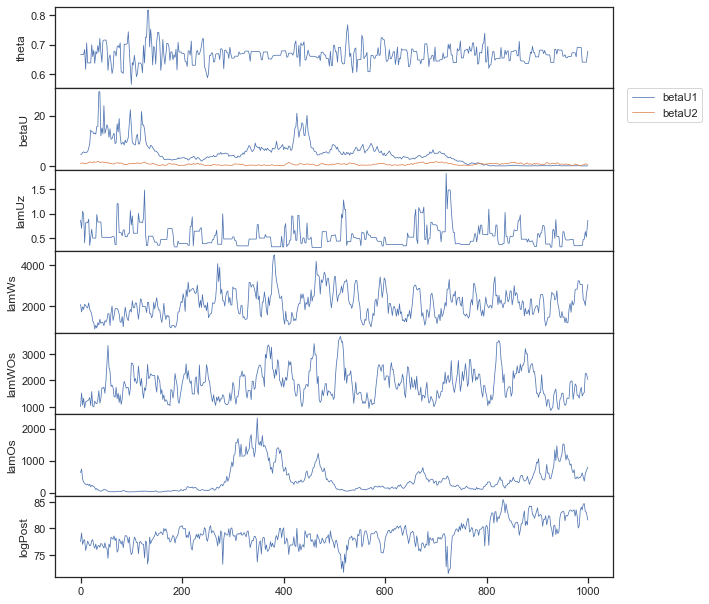

In [4]:
plot_trace(mod)

This plot shows this calibration setup and result in detail.

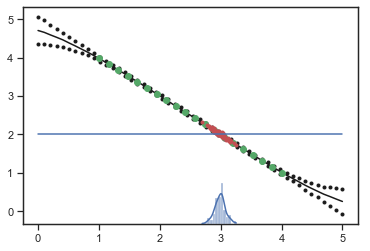

In [5]:
plot_cal(mod)

The green points are the simulator data. The black line is the fitted
emulator predictions of the simulations, with +/- 2sd shown in dotted black.
The blue line is the observation
value that is being calibrated, and the red points are the samples
of calibrated data, which are summarized in the inset histogram.

This works pretty well, although we see that the linear profile is breaking
down outside the range of the data.

We can do better by telling the model that we expect the process variance
to be large (the precision $\lambda$ to be small) - that is, to not try to keep the response in N(0,1).
Note that's N(0,1) on the "standardized" response scale; the $y$ values were
standardized as part of the model setup process; but in this case it's still
near s.d. = 1 on the plotted native scale for y.

MCMC sampling: 100%|██████████| 1000/1000 [00:01<00:00, 507.60it/s]


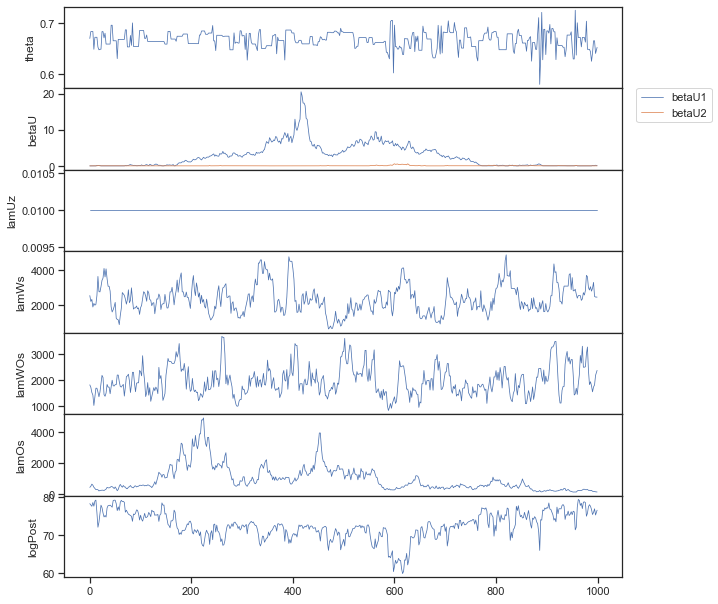

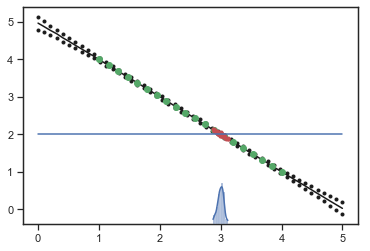

In [6]:
mod=run_model(m=20,fix_lamUz=0.01)
plot_trace(mod)
plot_cal(mod)

That fixes some of that problem.

It's still not going to be reliable extrapolating, though.
If extrapolation is important, that needs more thought than the default setup,
and is not the object of sepia.

But, let's see the same thing for 4 data points:

MCMC sampling: 100%|██████████| 1000/1000 [00:02<00:00, 484.11it/s]


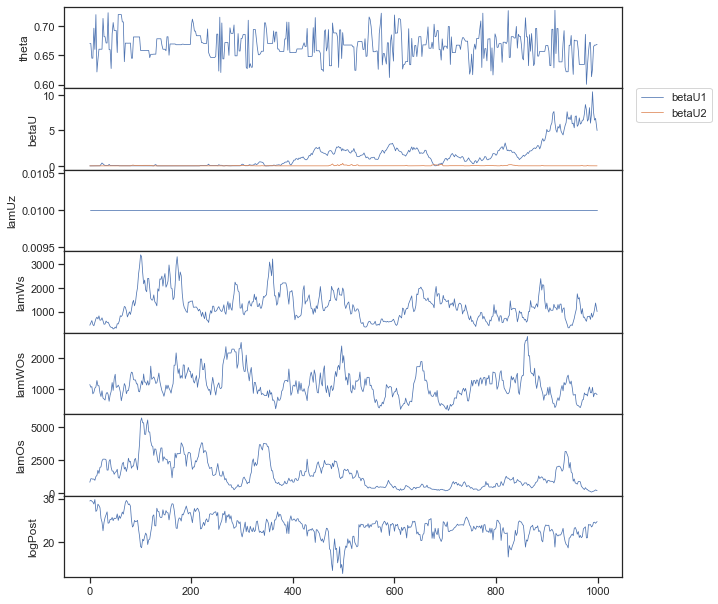

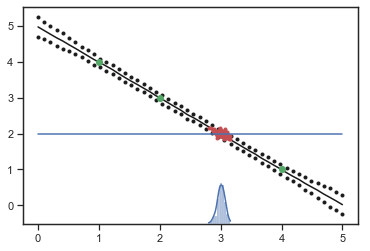

In [7]:
mod=run_model(m=4, fix_lamUz=0.01)
plot_trace(mod)
plot_cal(mod)

What happened: 4 samples is not much data to determine the relatively complex
sepia model. The 4 sample model thus is informed by priors, and finds
uncertainty in the balance between noisy simulator points and model smoothness.

This is addressed by fixing the two noise precisions lamWOs and lamWs:

MCMC sampling: 100%|██████████| 1000/1000 [00:01<00:00, 730.76it/s]


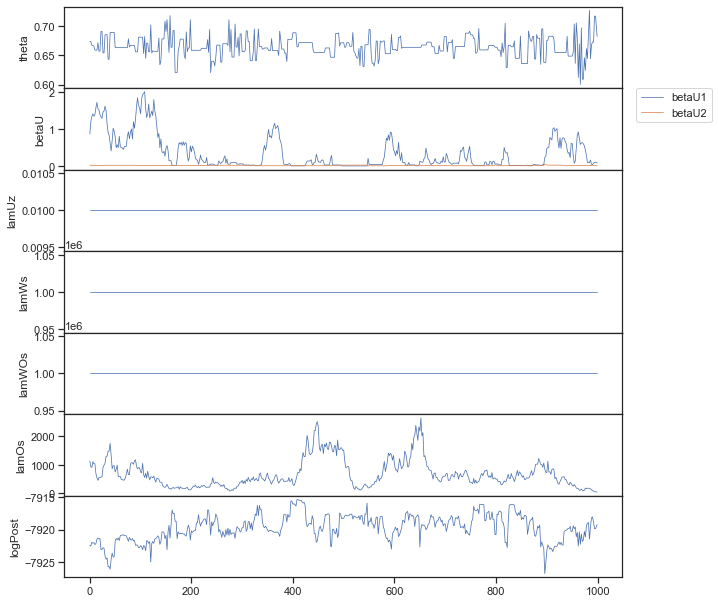

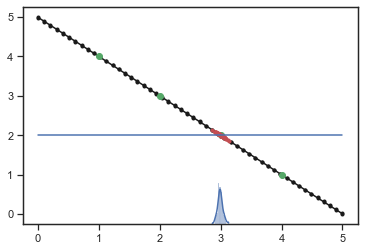

In [8]:
mod=run_model(m=4,fix_lamUz=0.01, fix_lamWOs=1e6, fix_lamWs=1e6)
plot_trace(mod)
plot_cal(mod)

### Conclusion
The Gaussian process has implicit assumptions that allow it to fit nonlinear
emulators. If it is known that the emulator is linear, we need to bring that
information to the model, either as plentiful data or by setting the parameters
to appropriate values. More properly stated and implemented:
the parameters should be controlled by
appropriate prior specification. However, for this discussion, fixing the parameter
values demonstrates clearly their effect on the model's fitting and calibration.